## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

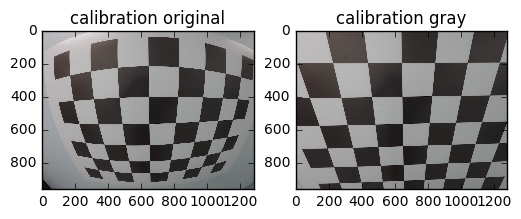

In [2]:
# Calibration with Chessboard images
def call_m():
    # Test undistortion on an image
    img = cv2.imread('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Submit2/camera_cal/GOPR0041.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (img.shape[1], img.shape[0])


    nx = 8
    ny = 6

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    objectp = np.zeros((nx*ny,3), np.float32)
    objectp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    imgp = []
    objp = []

    if ret == True:
        imgp.append(corners)
        objp.append(objectp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, gray.shape[::-1],None,None)

    dst = cv2.undistort(img,mtx,dist,None,mtx)

#     plt.subplot(121),plt.imshow(img),plt.title('calibration original')
#     plt.subplot(122),plt.imshow(dst),plt.title('calibration gray')
#     plt.show()
    
    return ret, mtx, dist, rvecs, tvecs
# Test undistortion on an image
img = cv2.imread('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Submit2/camera_cal/GOPR0041.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_size = (img.shape[1], img.shape[0])


nx = 8
ny = 6

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

objectp = np.zeros((nx*ny,3), np.float32)
objectp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

imgp = []
objp = []

if ret == True:
    imgp.append(corners)
    objp.append(objectp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, gray.shape[::-1],None,None)

dst = cv2.undistort(img,mtx,dist,None,mtx)

plt.subplot(121),plt.imshow(img),plt.title('calibration original')
plt.subplot(122),plt.imshow(dst),plt.title('calibration gray')
plt.show()


## 1. UNDISTORT Street view image 

#### Apply calibrated setting to the street view

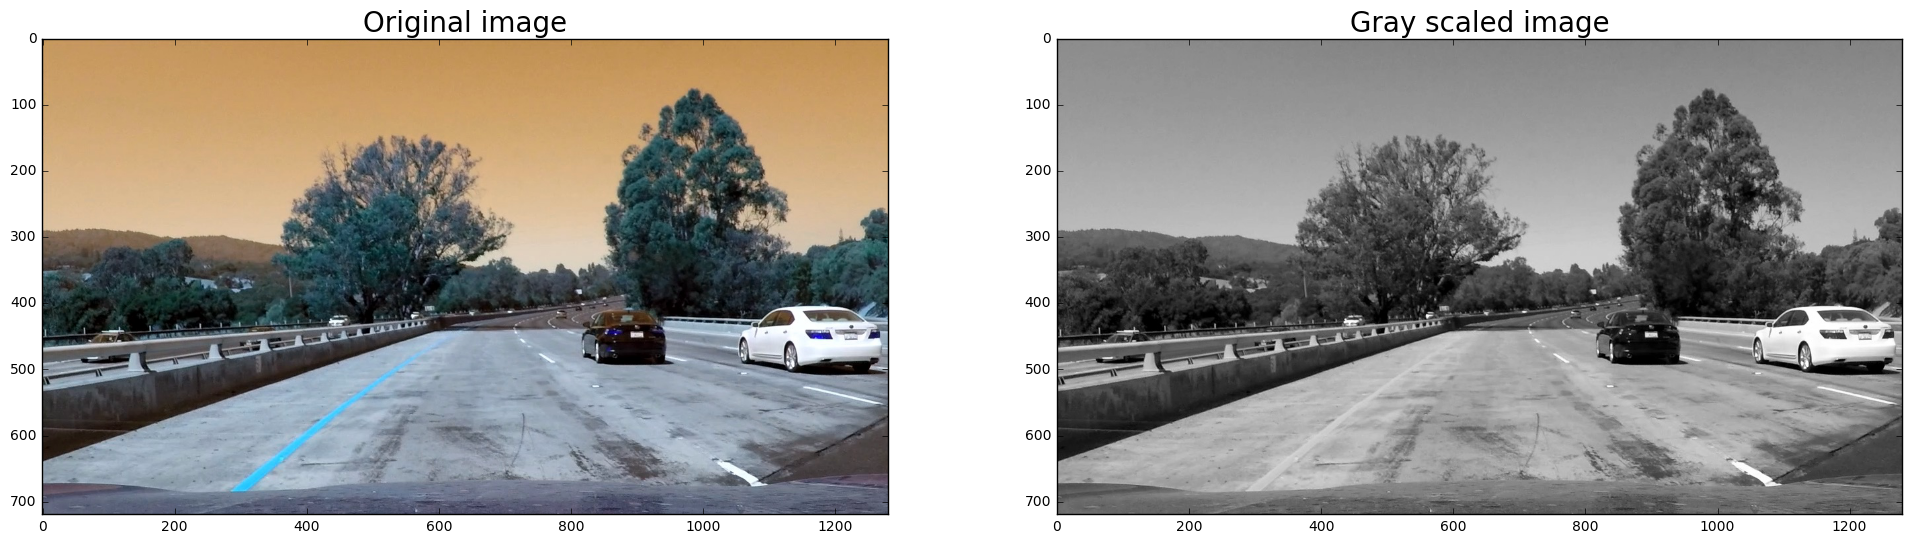

In [3]:
# Test undistortion on an image

img = cv2.imread('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Submit2/test_images/test1.jpg')
# save = cv2.imread('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/submit2/IMAGE/img 1036.jpg')

# img = save

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_size = (img.shape[1], img.shape[0])

f, (ax1, ax2) = plt.subplots(1,2, figsize = (24,10))
ax1.set_title('Original image', fontsize= 20)
ax1.imshow(img)
ax2.set_title('Gray scaled image', fontsize= 20)
ax2.imshow(gray, cmap='gray')


In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, gray.shape[::-1],None,None)

dst = cv2.undistort(img,mtx,dist,None,mtx)

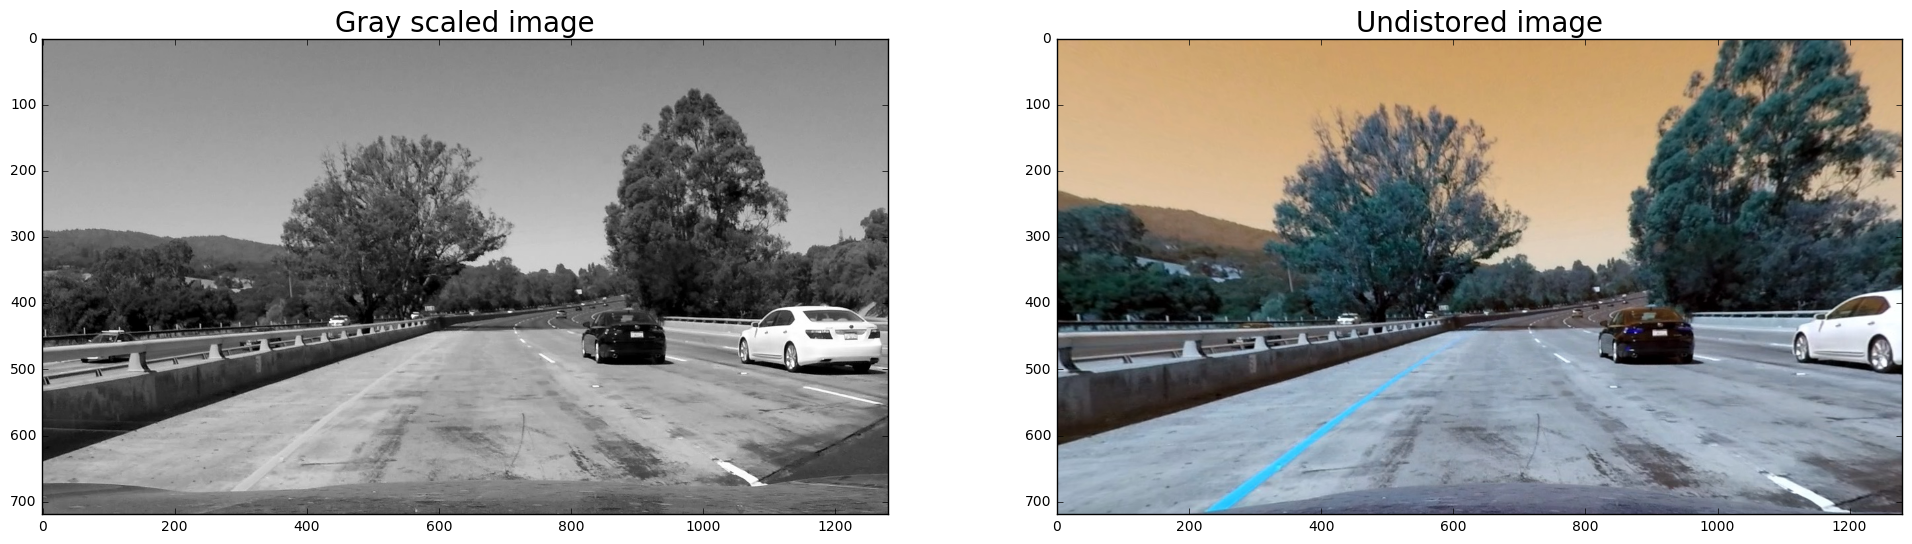

In [5]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (24,10))
ax1.set_title('Gray scaled image', fontsize= 20)
ax1.imshow(gray, cmap='gray')
ax2.set_title('Undistored image', fontsize= 20)
ax2.imshow(dst, cmap='gray')

## 2. COLOR BINARY THRESHOLD

#### Apply color threshold to the undistored image above
#### Find a distinct lanes with the proper threshold

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel = 1, thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize = sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arctan)
    
    # 6) Return this mask as your binary_output image
    binary_output[(arctan>=thresh[0])&(arctan<=thresh[1])] = 1 
#     binary_output = np.copy(img) # Remove this line
    return binary_output

# HLS threshold (H,L,S)

In [7]:
hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
hls_H = hls[:,:,0]
hls_L = hls[:,:,1]
hls_S = hls[:,:,2]
hls_thresh = (50, 100)

def hls_img(color, thresh):
    binary = np.zeros_like(color)
    binary[(color > thresh[0]) & (color <= thresh[1])] = 1
    return binary

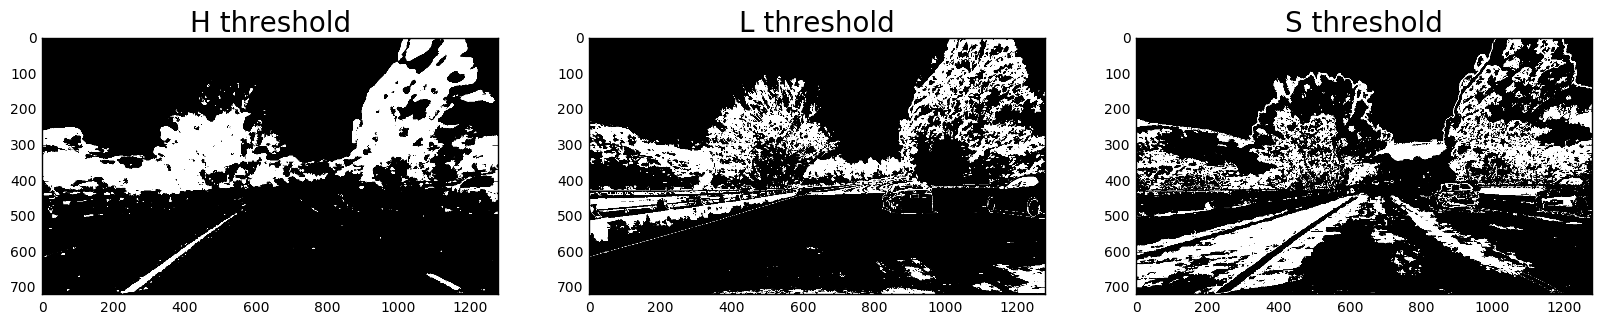

In [8]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,10))
ax1.set_title('H threshold', fontsize= 20)
ax1.imshow(hls_img(hls_H, hls_thresh), cmap = 'gray')
ax2.set_title('L threshold', fontsize= 20)
ax2.imshow(hls_img(hls_L, hls_thresh), cmap = 'gray')
ax3.set_title('S threshold', fontsize= 20)
ax3.imshow(hls_img(hls_S, hls_thresh), cmap = 'gray')


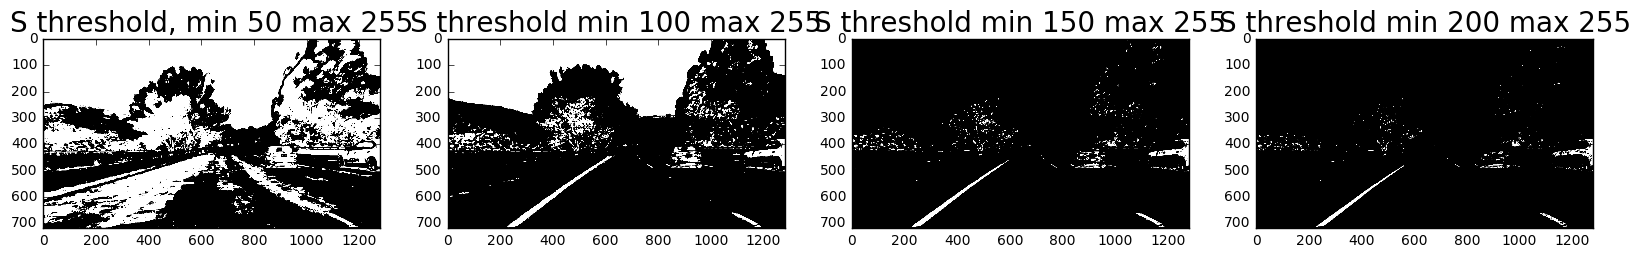

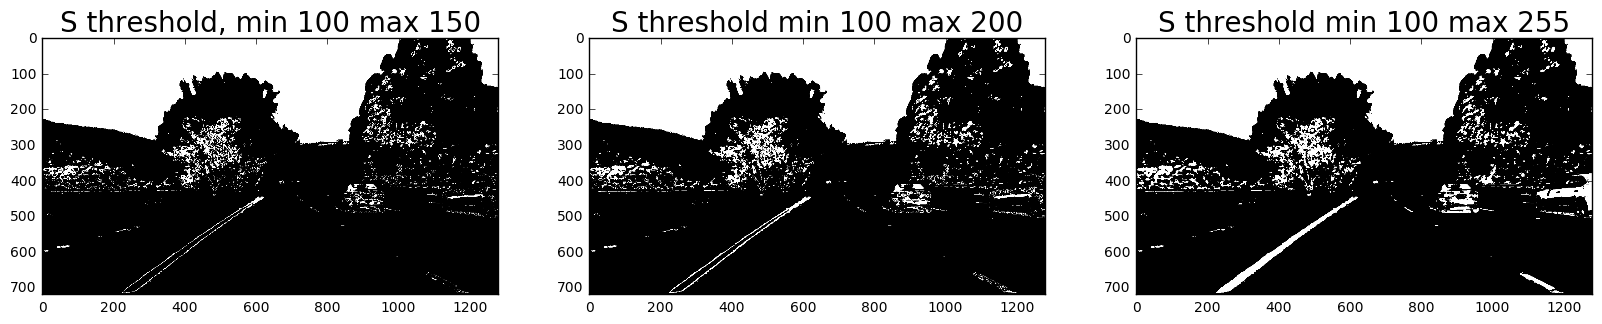

In [9]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (20,10))
ax1.set_title('S threshold, min 50 max 255', fontsize= 20)
ax1.imshow(hls_img(hls_S, (50,255)), cmap = 'gray')
ax2.set_title('S threshold min 100 max 255', fontsize= 20)
ax2.imshow(hls_img(hls_S, (100,255)), cmap = 'gray')
ax3.set_title('S threshold min 150 max 255', fontsize= 20)
ax3.imshow(hls_img(hls_S, (150,255)), cmap = 'gray')
ax4.set_title('S threshold min 200 max 255', fontsize= 20)
ax4.imshow(hls_img(hls_S, (200,255)), cmap = 'gray')

f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,10))
ax1.set_title('S threshold, min 100 max 150', fontsize= 20)
ax1.imshow(hls_img(hls_S, (100,150)), cmap = 'gray')
ax2.set_title('S threshold min 100 max 200', fontsize= 20)
ax2.imshow(hls_img(hls_S, (100,200)), cmap = 'gray')
ax3.set_title('S threshold min 100 max 255', fontsize= 20)
ax3.imshow(hls_img(hls_S, (100,255)), cmap = 'gray')



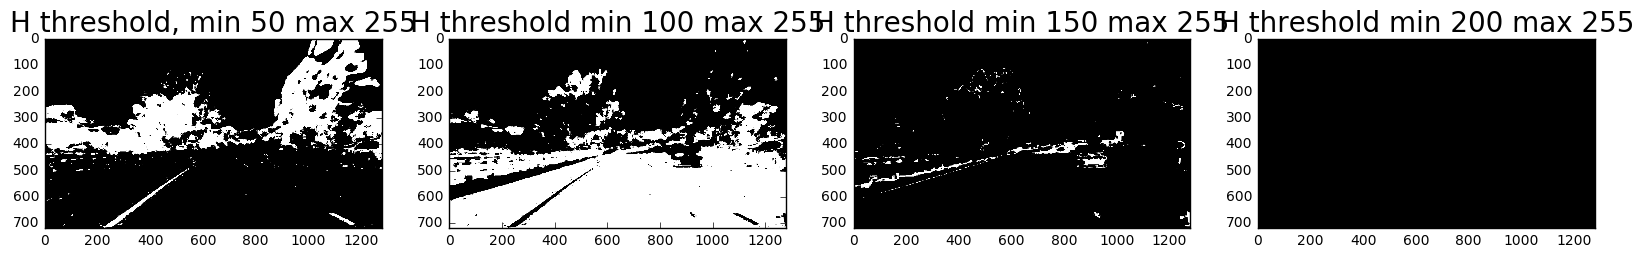

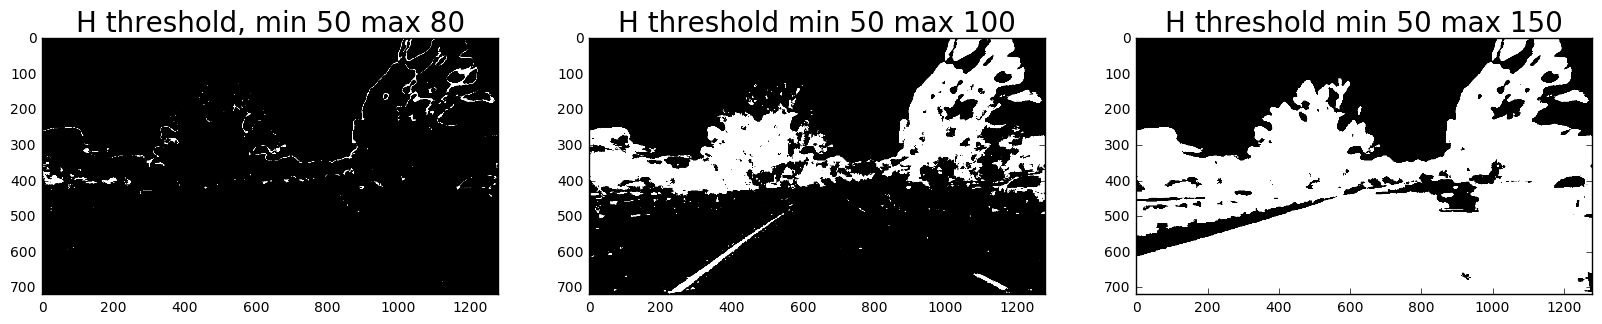

In [10]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (20,10))
ax1.set_title('H threshold, min 50 max 255', fontsize= 20)
ax1.imshow(hls_img(hls_H, (50,100)), cmap = 'gray')
ax2.set_title('H threshold min 100 max 255', fontsize= 20)
ax2.imshow(hls_img(hls_H, (100,155)), cmap = 'gray')
ax3.set_title('H threshold min 150 max 255', fontsize= 20)
ax3.imshow(hls_img(hls_H, (150,205)), cmap = 'gray')
ax4.set_title('H threshold min 200 max 255', fontsize= 20)
ax4.imshow(hls_img(hls_H, (200,255)), cmap = 'gray')

f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,10))
ax1.set_title('H threshold, min 50 max 80', fontsize= 20)
ax1.imshow(hls_img(hls_H, (50,80)), cmap = 'gray')
ax2.set_title('H threshold min 50 max 100', fontsize= 20)
ax2.imshow(hls_img(hls_H, (50,100)), cmap = 'gray')
ax3.set_title('H threshold min 50 max 150', fontsize= 20)
ax3.imshow(hls_img(hls_H, (50,150)), cmap = 'gray')



# HSV threshold (H,S,V)

In [11]:
hsv = cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)
hsv_H = hsv[:,:,0]
hsv_S = hsv[:,:,1]
hsv_V = hsv[:,:,2]
hsv_thresh = (200,250)

def hsv_img(color, thresh):
    binary = np.zeros_like(color)
    binary[(color > thresh[0]) & (color <= thresh[1])] = 1
    return binary

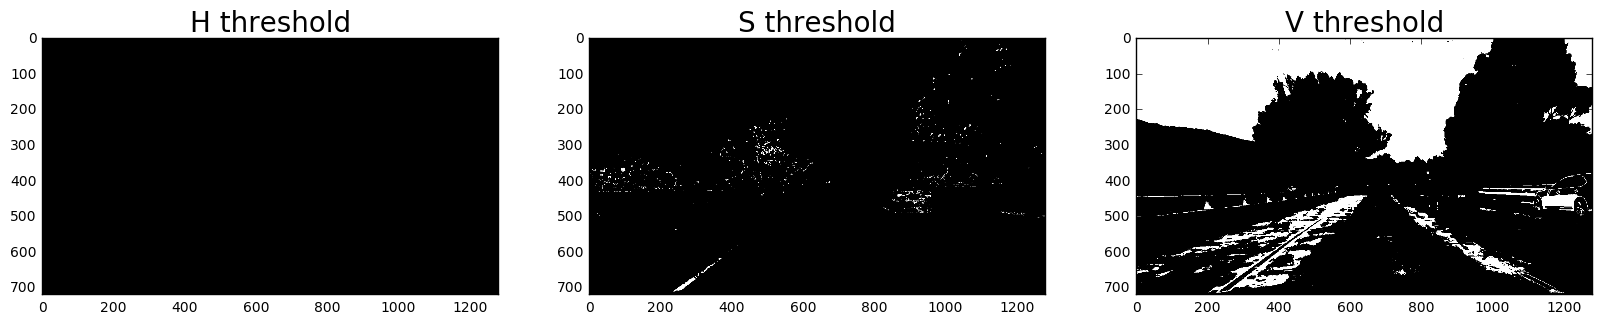

In [12]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,10))
ax1.set_title('H threshold', fontsize= 20)
ax1.imshow(hls_img(hsv_H, hsv_thresh), cmap = 'gray')
ax2.set_title('S threshold', fontsize= 20)
ax2.imshow(hls_img(hsv_S, hsv_thresh), cmap = 'gray')
ax3.set_title('V threshold', fontsize= 20)
ax3.imshow(hls_img(hsv_V, hsv_thresh), cmap = 'gray')



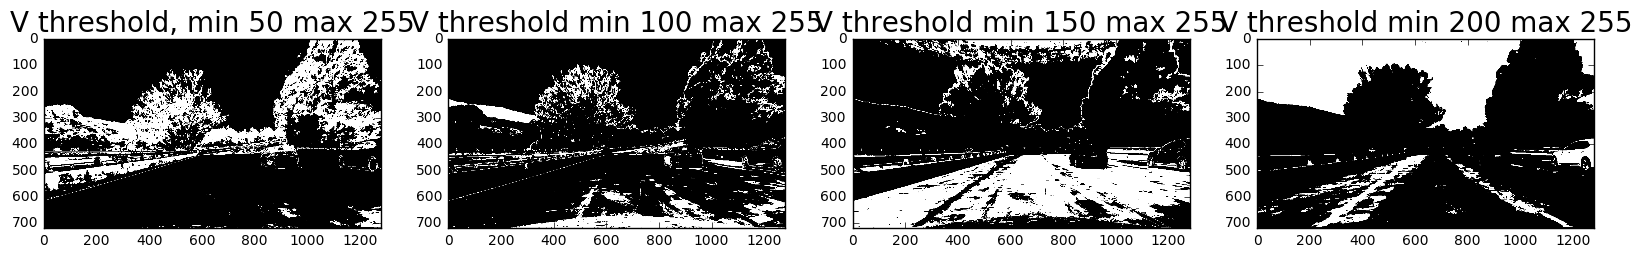

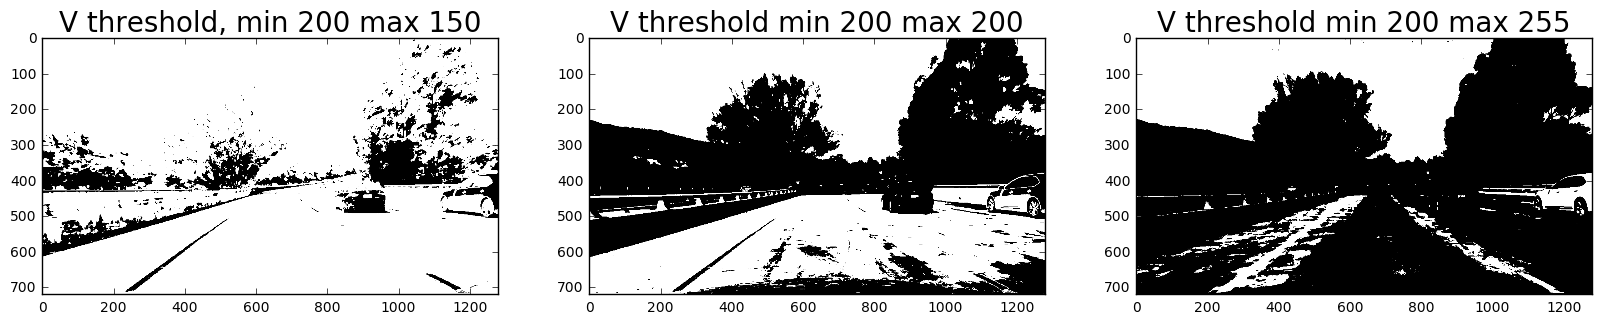

In [13]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (20,10))
ax1.set_title('V threshold, min 50 max 255', fontsize= 20)
ax1.imshow(hsv_img(hsv_V, (50,100)), cmap = 'gray')
ax2.set_title('V threshold min 100 max 255', fontsize= 20)
ax2.imshow(hsv_img(hsv_V, (100,155)), cmap = 'gray')
ax3.set_title('V threshold min 150 max 255', fontsize= 20)
ax3.imshow(hsv_img(hsv_V, (150,205)), cmap = 'gray')
ax4.set_title('V threshold min 200 max 255', fontsize= 20)
ax4.imshow(hsv_img(hsv_V, (200,255)), cmap = 'gray')

f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,10))
ax1.set_title('V threshold, min 200 max 150', fontsize= 20)
ax1.imshow(hsv_img(hsv_V, (50,250)), cmap = 'gray')
ax2.set_title('V threshold min 200 max 200', fontsize= 20)
ax2.imshow(hsv_img(hsv_V, (150,250)), cmap = 'gray')
ax3.set_title('V threshold min 200 max 255', fontsize= 20)
ax3.imshow(hsv_img(hsv_V, (200,255)), cmap = 'gray')



### BEST OPTION IS HLS THRESHOLD (COLOR:S, THRESH:100,250)
### BEST OPTION IS HLS THRESHOLD (COLOR:H, THRESH:50,100)
### BEST OPTION IS HVS THRESHOLD (COLOR:V, THRESH:200,255)

### LET'S TRY OTHER PICTURES WHETHER THRESHOLD WORKS SAME AS BEFORE

## 1. HLS S threshold 100,250

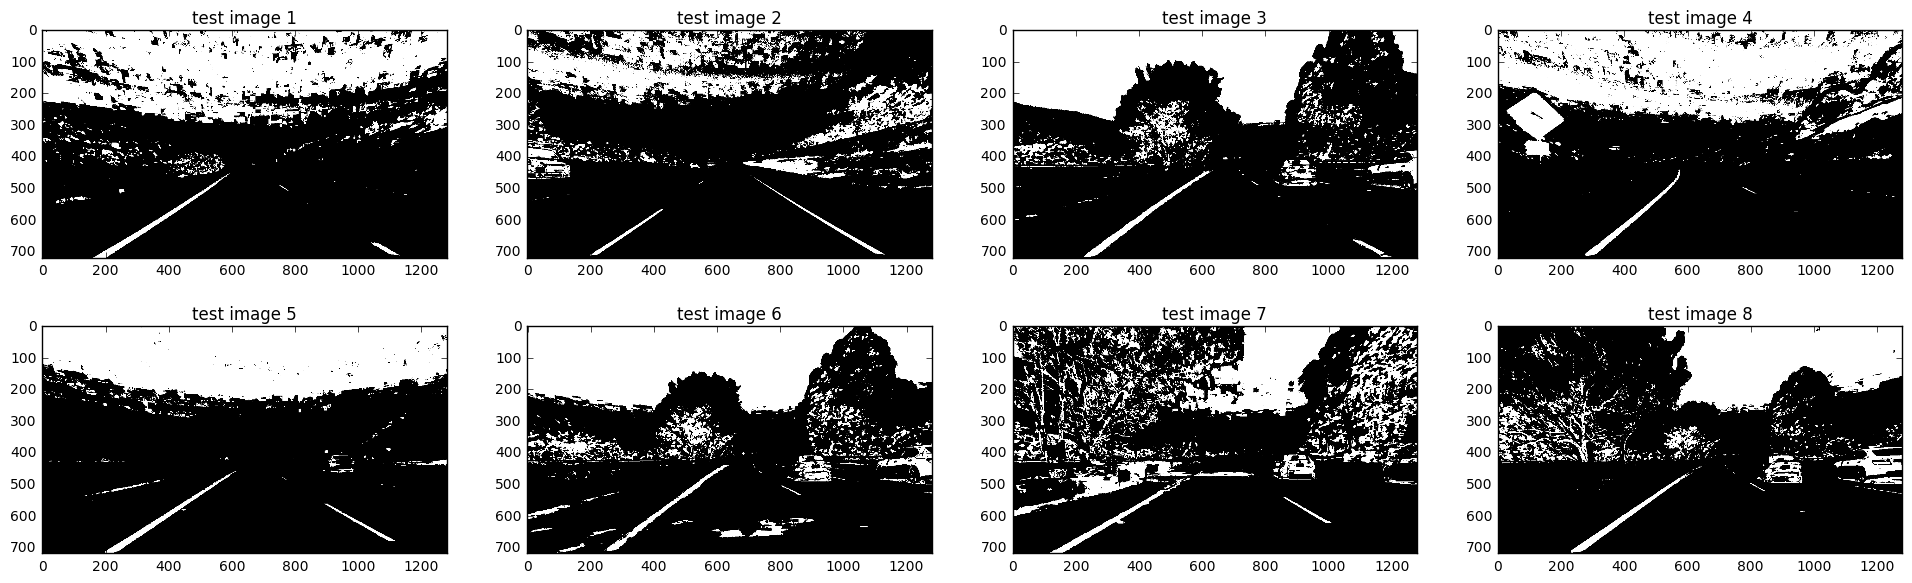

In [14]:
# Make a list of calibration images
images = glob.glob('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/test_images/*.jpg')

fig = plt.subplots(2,4, figsize = (24,7))
i = 0

# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)

    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    
    S = hls[:,:,2]
    
    thresh = (100, 255)
    
    n_dst = hls_img(S, thresh)
    
    temp = 241 + i
    ax = plt.subplot(temp)
    plt.imshow(n_dst, cmap = 'gray')
    ax.set_title('test image %i' %(i + 1))
    
    i = i+1
        

## SEEMS LIKE OKAY BUT A FEW IMAGES HAVE A NOISE

## 2. HLS H threshold 50, 100

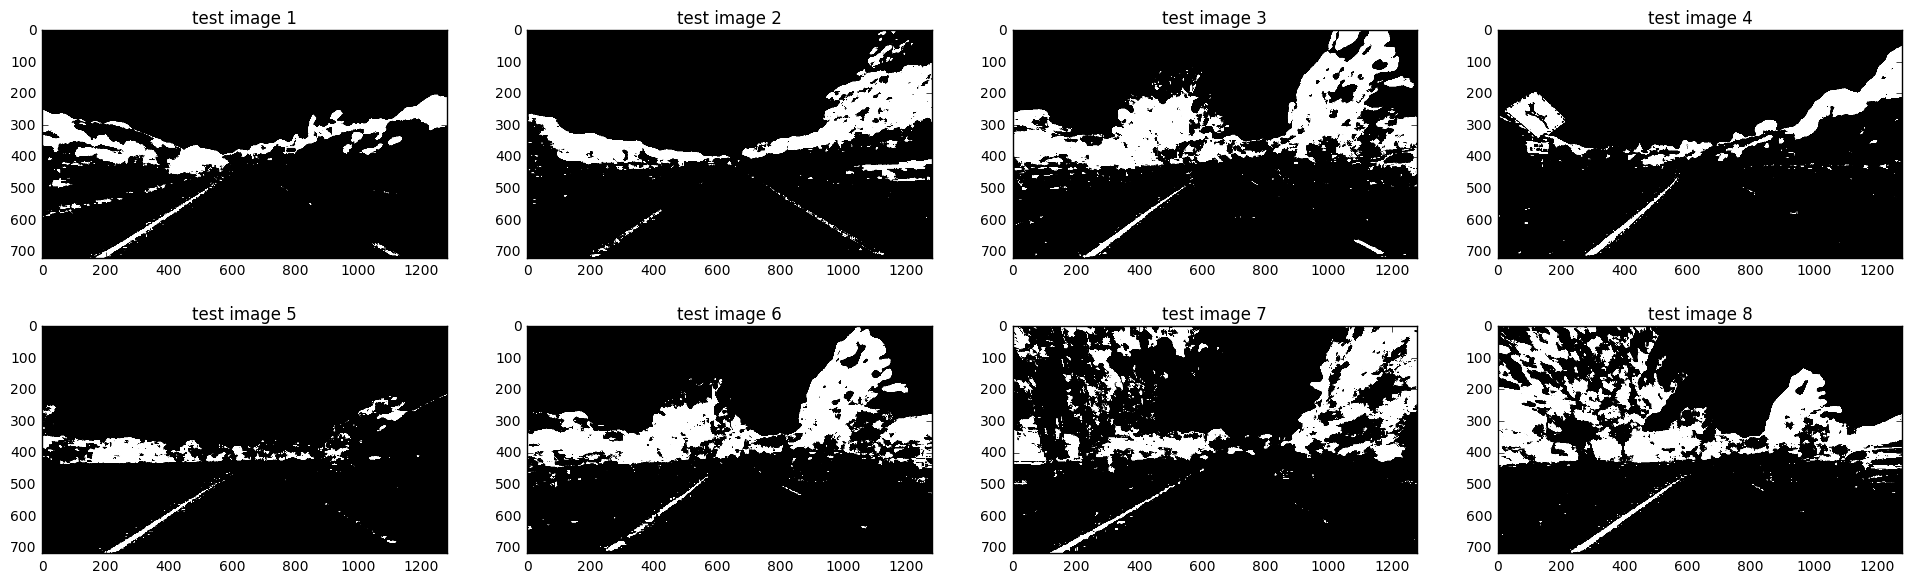

In [15]:
# Make a list of calibration images
images = glob.glob('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/test_images/*.jpg')

fig = plt.subplots(2,4, figsize = (24,7))
i = 0

# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)

    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    
    thresh = (50, 100)
    
    n_dst = hls_img(H, thresh)
    
    temp = 241 + i
    ax = plt.subplot(temp)
    plt.imshow(n_dst, cmap = 'gray')
    ax.set_title('test image %i' %(i + 1))
    
    i = i+1
        

## SEEMS LIKE WORKING BETTER THAN S THRESHOLD ABOVE

## 3. HSV V THRESHOLD 200, 250

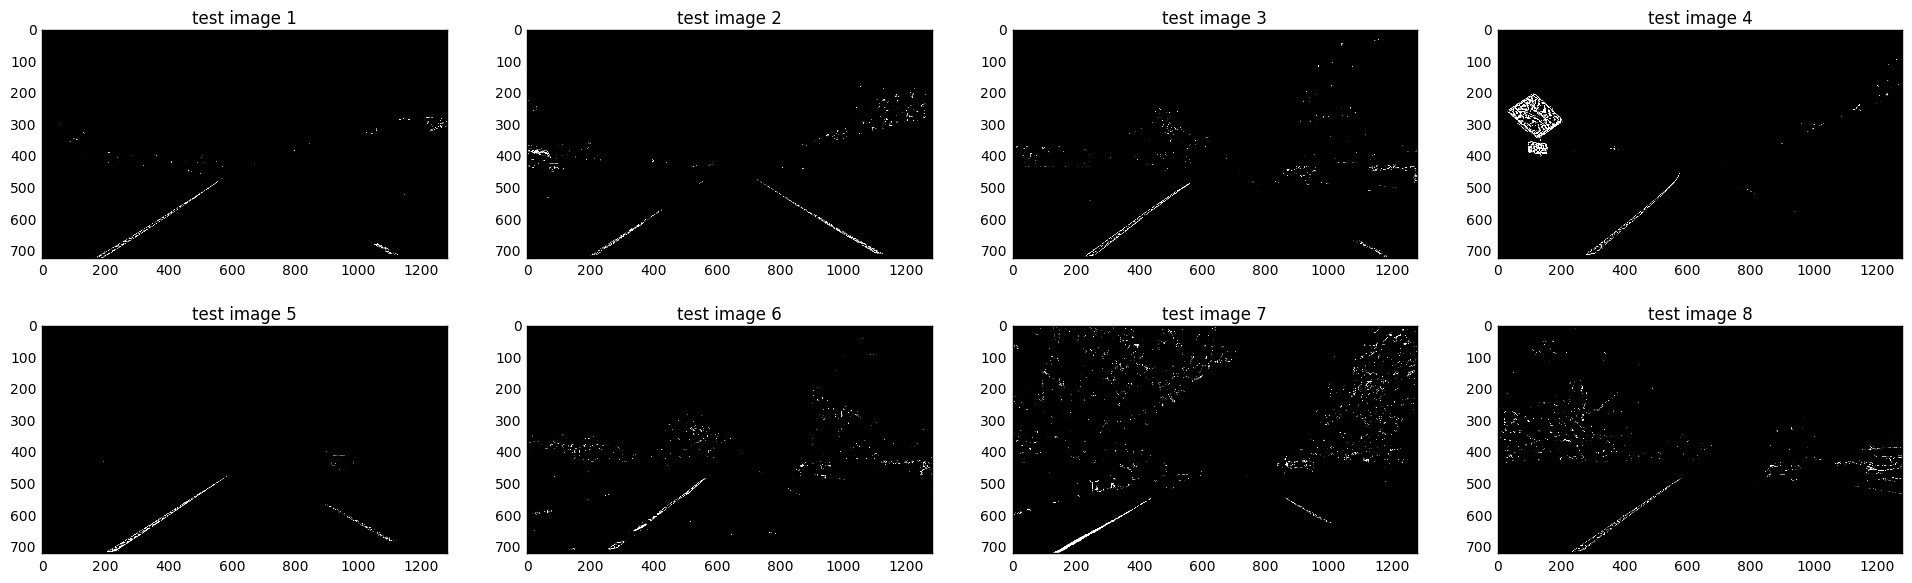

In [16]:
# Make a list of calibration images
images = glob.glob('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/test_images/*.jpg')

fig = plt.subplots(2,4, figsize = (24,7))
i = 0

# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)

    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    hsv = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    
    V = hsv[:,:,2]
    
    thresh = (200, 250)
    
    n_dst = hsv_img(V, thresh)
    
    temp = 241 + i
    ax = plt.subplot(temp)
    plt.imshow(n_dst, cmap = 'gray')
    ax.set_title('test image %i' %(i + 1))
    
    i = i+1
        

## It also looks like working but less than HLS H threshold and it catches almost the same as HLS H threshold did. Right lane is...

## Applied color threshold so far, Lets try Gradient threshold,

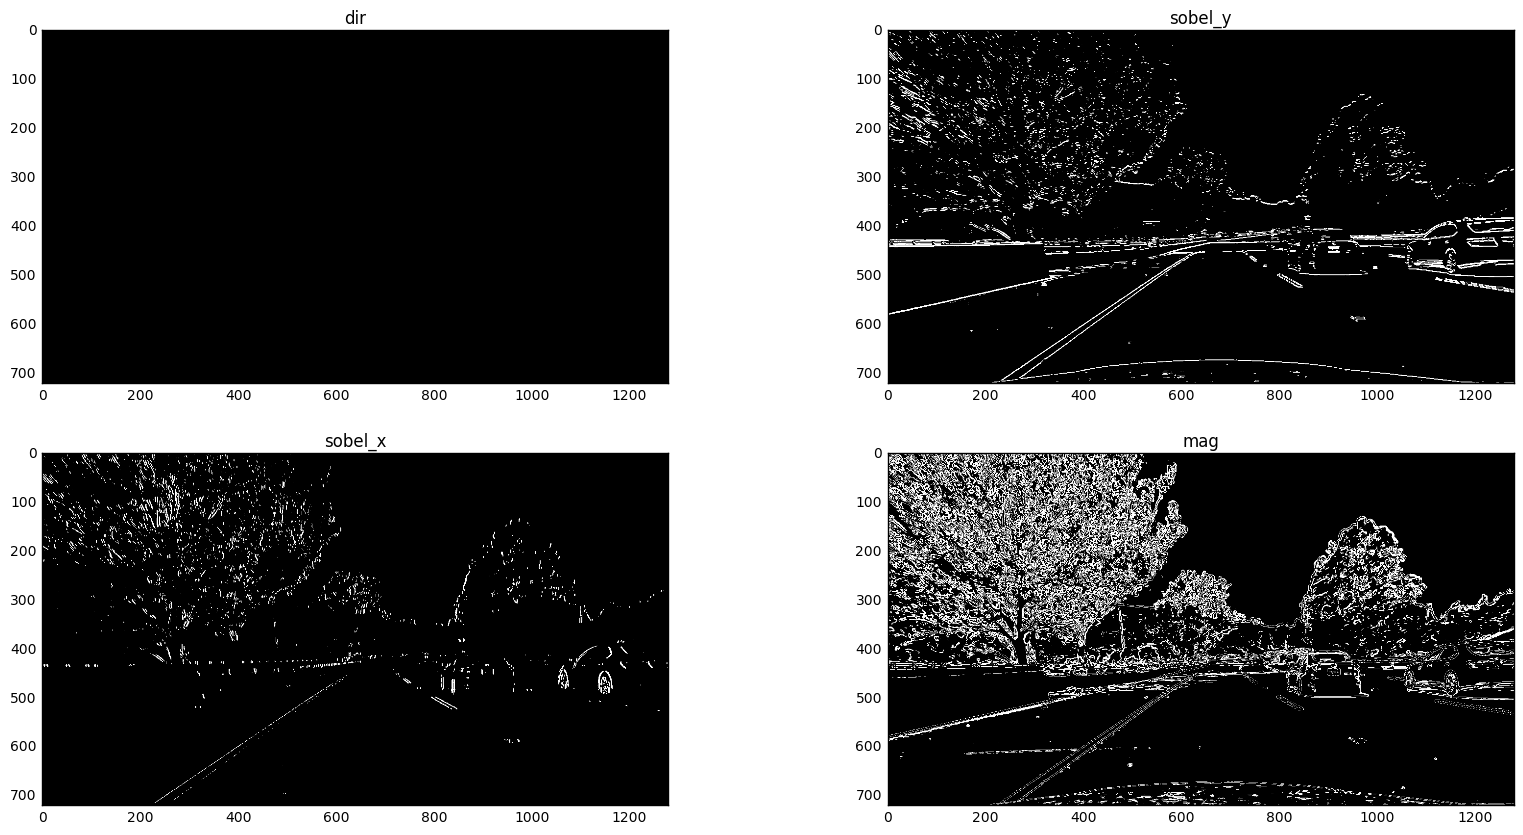

In [17]:
plt.subplots(figsize = (20,10))
plt.subplot(221),plt.imshow(dir_threshold(dst, thresh =(0,5)), cmap='gray'),plt.title('dir')
plt.subplot(222),plt.imshow(abs_sobel_thresh(dst, orient = 'y', thresh_min = 50, thresh_max = 200), cmap='gray'),plt.title('sobel_y')
plt.subplot(223),plt.imshow(abs_sobel_thresh(dst, orient = 'x', sobel_kernel = 1, thresh_min = 50, thresh_max = 250), cmap='gray'),plt.title('sobel_x')
plt.subplot(224),plt.imshow(mag_thresh(dst, mag_thresh=(20,50)), cmap='gray'),plt.title('mag')
plt.show()


## SOBEL_X WITH TEST IMAGES

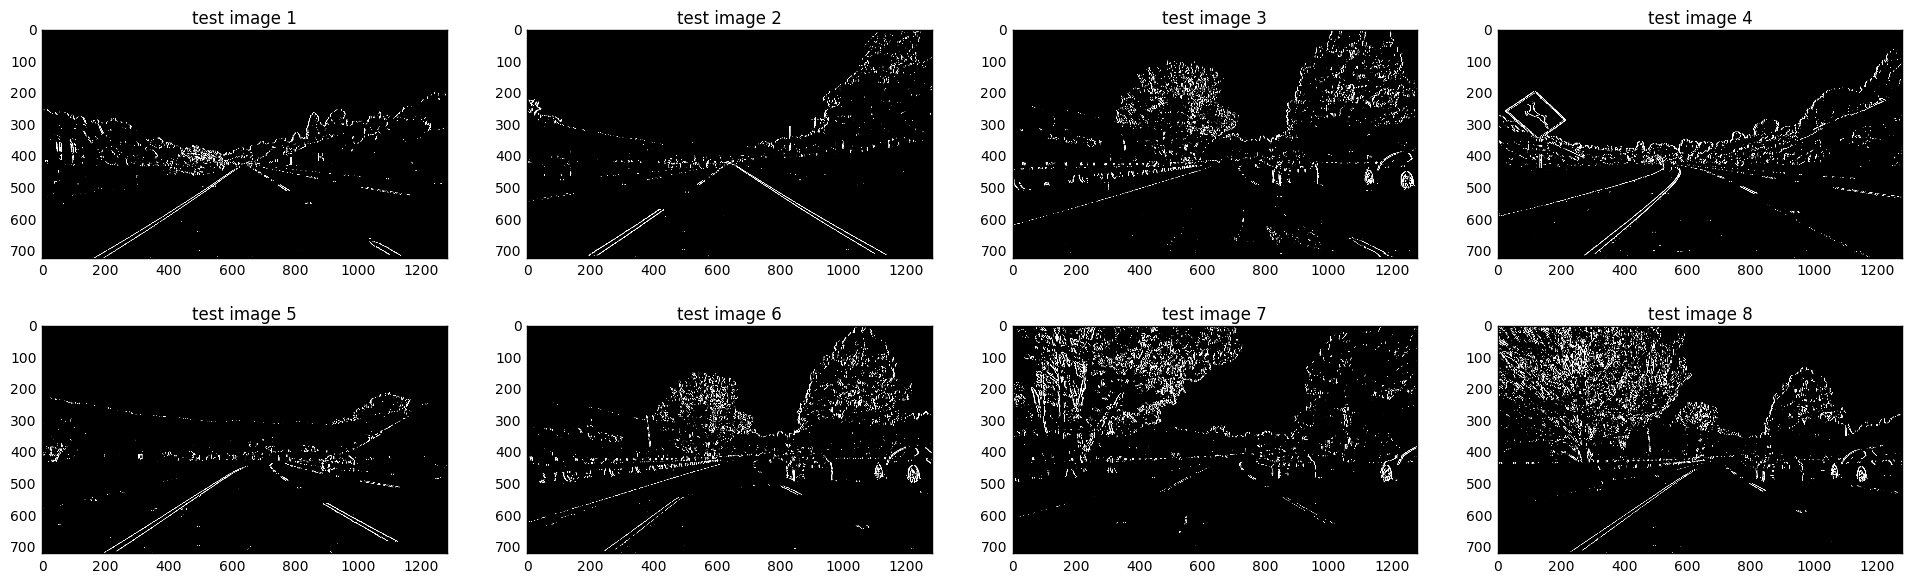

In [18]:
# Make a list of calibration images
images = glob.glob('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/test_images/*.jpg')

fig = plt.subplots(2,4, figsize = (24,7))
i = 0

# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)

    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    n_dst = abs_sobel_thresh(dst, orient = 'x', sobel_kernel = 1, thresh_min = 30, thresh_max = 250)
    
    temp = 241 + i
    ax = plt.subplot(temp)
    plt.imshow(n_dst, cmap = 'gray')
    ax.set_title('test image %i' %(i + 1))
    
    i = i+1
        

## SOBEL Y  WITH TEST IMAGES

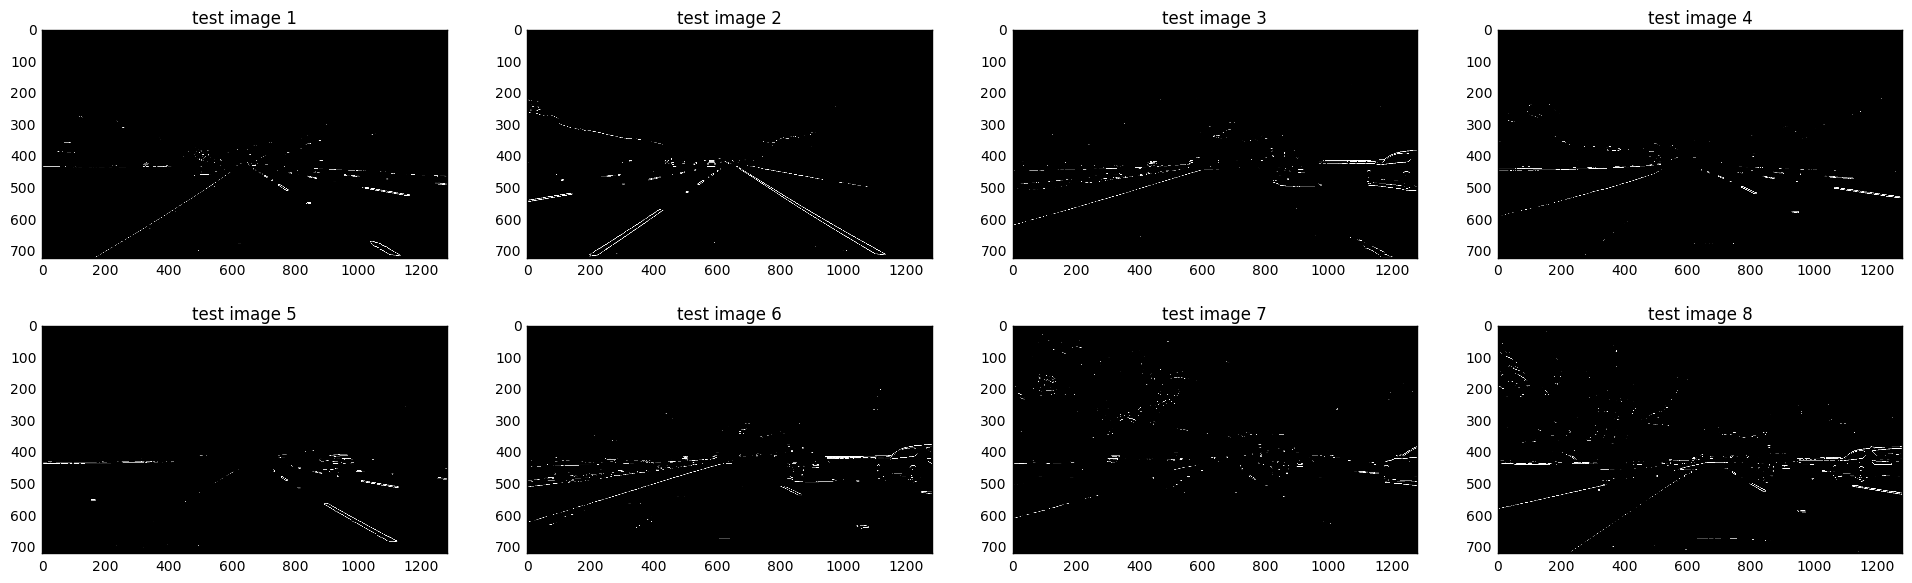

In [19]:
# Make a list of calibration images
images = glob.glob('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/test_images/*.jpg')

fig = plt.subplots(2,4, figsize = (24,7))
i = 0

# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)

    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    n_dst = abs_sobel_thresh(dst, orient = 'y', sobel_kernel = 1, thresh_min = 100, thresh_max = 250)
    
    temp = 241 + i
    ax = plt.subplot(temp)
    plt.imshow(n_dst, cmap = 'gray')
    ax.set_title('test image %i' %(i + 1))
    
    i = i+1
        

## SOBEL X AND Y BOTH COULD BE WORKING WITH HLS THRESHOLD COMBINED EACH OTHER

## COMBINED1 : HLS S THRESHOLD + SOBEL X OR SOBEL Y --> Failed
## COMBINED2 : HLS H THRESHOLD + SOBEL X OR SOBEL Y
## COMBINED3 : HSV V THRESHOLD + HLS H THRESHOLD + SOBEL X OR SOBEL Y

In [20]:
def hsV_sobely(img):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    V = hsv[:,:,2]
    
    thresh = (200, 250)
    
    n_dst1 = hsv_img(V, thresh)
    
    n_dst2 = abs_sobel_thresh(img, orient = 'y', sobel_kernel = 1, thresh_min = 100, thresh_max = 250)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(n_dst1)
    combined_binary[(n_dst1 == 1) | (n_dst2 == 1)] = 1

    return combined_binary  

In [21]:
def Hls_sobely(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    
    thresh = (50, 100)
    
    n_dst1 = hls_img(H, thresh)
    
    n_dst2 = abs_sobel_thresh(img, orient = 'y', sobel_kernel = 1, thresh_min = 100, thresh_max = 250)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(n_dst1)
    combined_binary[(n_dst1 == 1) | (n_dst2 == 1)] = 1

    return combined_binary

In [22]:
def tp_cvt(lst):
    b = np.zeros(lst.shape)
    i = 0
    for a in lst:
#         print(a)
        b[i] = tuple(a[::-1])
#         print(b[i])
        i = i+1
    return np.int32(b)

## Select range for lanes

In [43]:

hls = hsV_sobely(dst)


# hls = hls_img(S,thresh)
img_size = hls.shape
img_size = img.shape
print(img_size)

(720, 1280, 3)


In [44]:
src = np.int32(
    [
    [(img_size[1] / 2) - 45, img_size[0] / 2 + 100],
    [(img_size[1] / 2) + 105, img_size[0] / 2 + 100],
    [ img_size[1] / 2 + 600, img_size[0]],
    [ img_size[1] / 2 - 480, img_size[0]]])

# src_ = np.int32(
#     [
#     [(img_size[1] / 2) - 45, img_size[0] / 2 + 90],
#     [(img_size[1] / 2) + 105, img_size[0] / 2 + 90],
#     [ img_size[1] / 2 + 600, img_size[0]],
#     [ img_size[1] / 2 - 480, img_size[0]]])



print(src)
# src = src.reshape([-1,1,2])
dst_ = np.int32(
    [[(img_size[1]/ 2 - 60), 0],
    [(img_size[1] / 2 - 60), img_size[0]/2 + 80],
    [(img_size[0]), img_size[0]/2 + 80],
    [(img_size[0]), 0]])

src_rev = tp_cvt(src)

print(dst_)

[[ 595  460]
 [ 745  460]
 [1240  720]
 [ 160  720]]
[[580   0]
 [580 440]
 [720 440]
 [720   0]]


In [45]:
src_cvt = tp_cvt(src)
src_int = np.int32(src)

(720, 1280, 3) (720, 1280, 3)


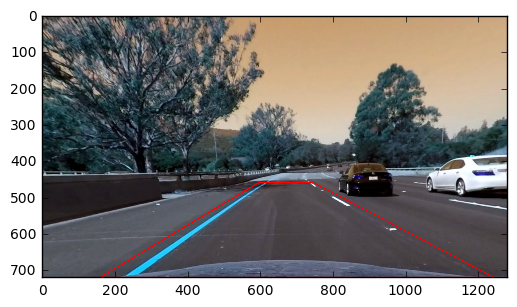

In [46]:
dst = cv2.undistort(img,mtx,dist,None,mtx)

pt = np.ones(dst.shape)
print(pt.shape, dst.shape)
cv2.polylines(dst, [src], True, [255,0,0],2)
plt.imshow(dst)
# plt.subplots(212),plt.imshow()


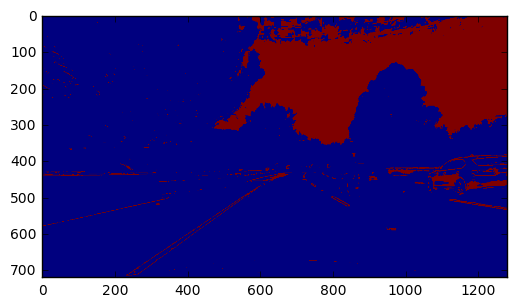

In [47]:
plt.imshow(hls)
# hls_img(S,thresh)

## Warped undistored image

In [48]:
def order_points(pts):

	rect = np.zeros((4, 2), dtype = "int32")
	pts = pts.reshape([-1,2])
    
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	return rect

def four_point_transform(image, rect):

	(tl, tr, br, bl) = rect

	dst = np.int32([[image.shape[1]/2-600,0],[image.shape[1]/2+600,0],[image.shape[1]/2+600,720],[image.shape[1]/2-600,720]])

	M = cv2.getPerspectiveTransform(np.float32(rect), np.float32(dst))
	warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

	return dst, M, warped

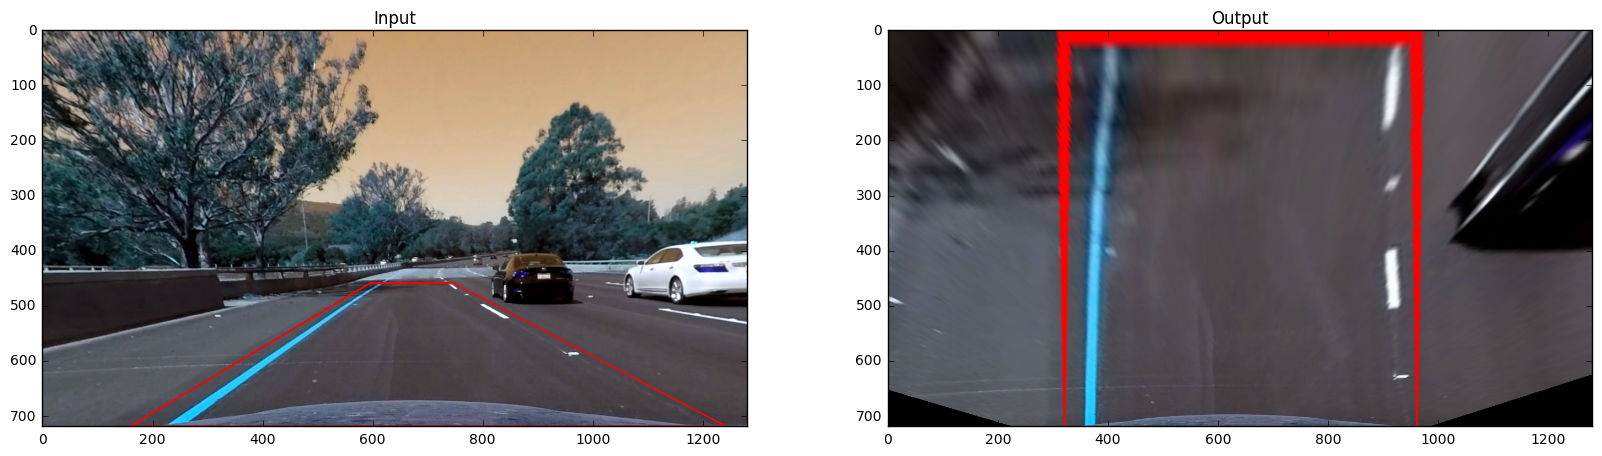

In [49]:

dst = cv2.undistort(img,mtx,dist,None,mtx)
# dst_ = np.int32([[dst.shape[1]/2-600,0],[dst.shape[1]/2+600,0],[dst.shape[1]/2+600,720],[dst.shape[1]/2-600,720]])

# dst = hsV_sobely(dst)

dst_ = np.int32([[320,0],[960,0],[960,720],[320,720]])
cv2.polylines(dst, [src], True, [255,0,0],2)

M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst_))
Minv = cv2.getPerspectiveTransform(np.float32(dst_), np.float32(src))

warped = cv2.warpPerspective(dst, M, (dst.shape[1], dst.shape[0]))
udist = cv2.warpPerspective(dst, Minv, (dst.shape[1], dst.shape[0]))


# plt.imshow(dst)
plt.subplots(figsize = (20,10))
plt.subplot(121),plt.imshow(dst),plt.title('Input')
plt.subplot(122),plt.imshow(warped),plt.title('Output')
# plt.subplot(133),plt.imshow(udist),plt.title('back')
plt.show()

In [50]:
dst, M, warped = four_point_transform(hls, src)

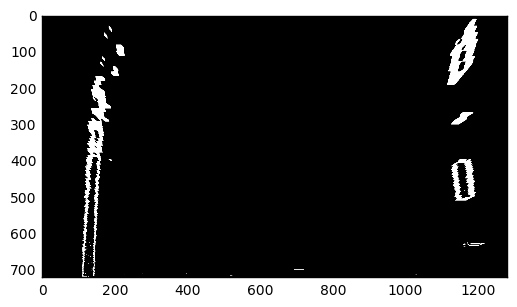

In [51]:
plt.imshow(warped, cmap='gray')

/Users/JAY/anaconda/envs/yourNewEnvironment/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


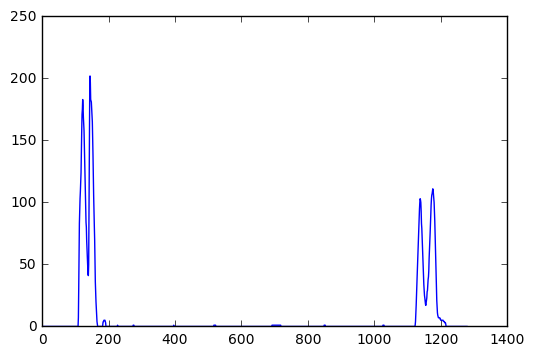

In [52]:
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

## Window lanes function & Test

In [53]:
binary_warped = warped

def win_lane(binary_warped):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit

In [54]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

/Users/JAY/anaconda/envs/yourNewEnvironment/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(720, 0)

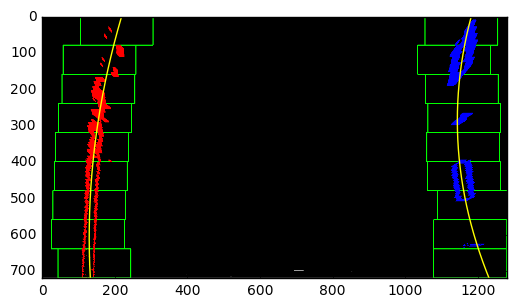

In [55]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Yellow line function & Test

In [56]:
def yel_lane(binary_warped):
    
    left_fit, right_fit = win_lane(binary_warped)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Define conversions in x and y from pixels space to meters

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    center_l = (out_img.shape[1]/2 - (left_fitx[len(left_fitx)-1]+right_fitx[len(right_fitx)-1])/2)*xm_per_pix
    cur_r = ((left_curverad + right_curverad)/2)
    
    
    text = "Radius of Curvature : %.3f m, Vehicle is %.3f m left of center" %(cur_r, center_l)
    # Example values: 632.1 m    626.2 m
    
#     cv2.putText(result,text,(300,300), cv2.FONT_HERSHEY_SIMPLEX, 3,(255,0,0),5)


    return result, left_fitx, right_fitx, ploty, text


In [57]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

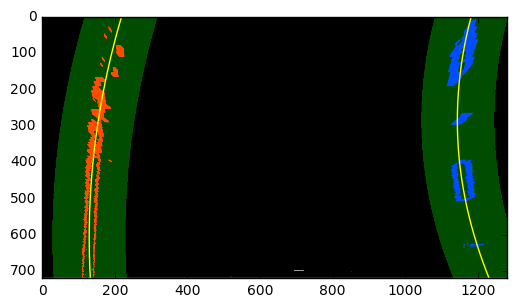

In [58]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

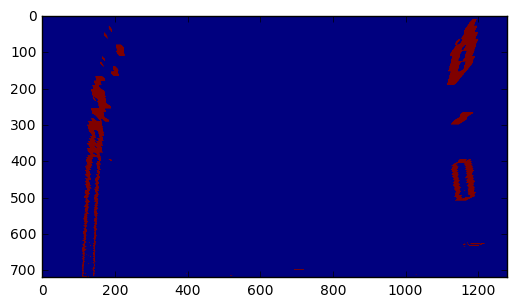

In [59]:
plt.imshow(warped)

127.0
126.0
130.0
137.0
145.0
152.0
150.0
201.0
167.0


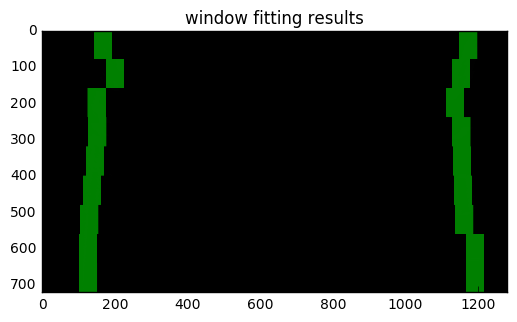

In [60]:
import matplotlib.image as mpimg


# Read in a thresholded image
# warped = mpimg.imread('../test_images/test3.jpg')

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
#     print(window_centroids)
#     print(len(window_centroids))
    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    print(window_centroids[level][0])
        
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [61]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

/Users/JAY/anaconda/envs/yourNewEnvironment/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


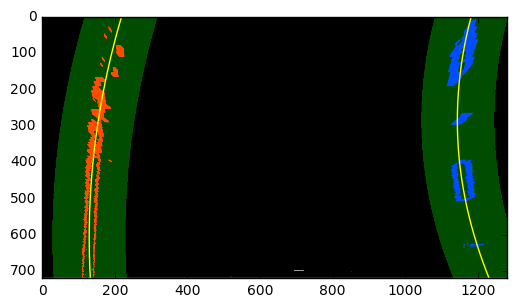

In [62]:

plt.imshow(result)

plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.plot(left_fitx, ploty, color='yellow', linewidth=1)
plt.plot(right_fitx, ploty, color='yellow', linewidth=1)
# plt.gca().invert_yaxis() # to visualize as we do the images

In [63]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

2082.85814876 1347.69665181


In [64]:
print(ploty.shape, leftx.shape)

(720,) (13337,)


In [65]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

681.180813137 m 354.655146456 m


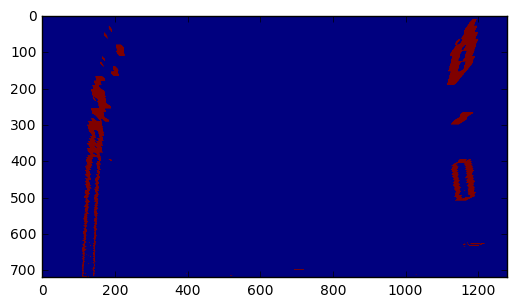

In [66]:
plt.imshow(warped)

## Final Test before running test video

[[ 565  460]
 [ 745  460]
 [1240  720]
 [ 120  720]]


/Users/JAY/anaconda/envs/yourNewEnvironment/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


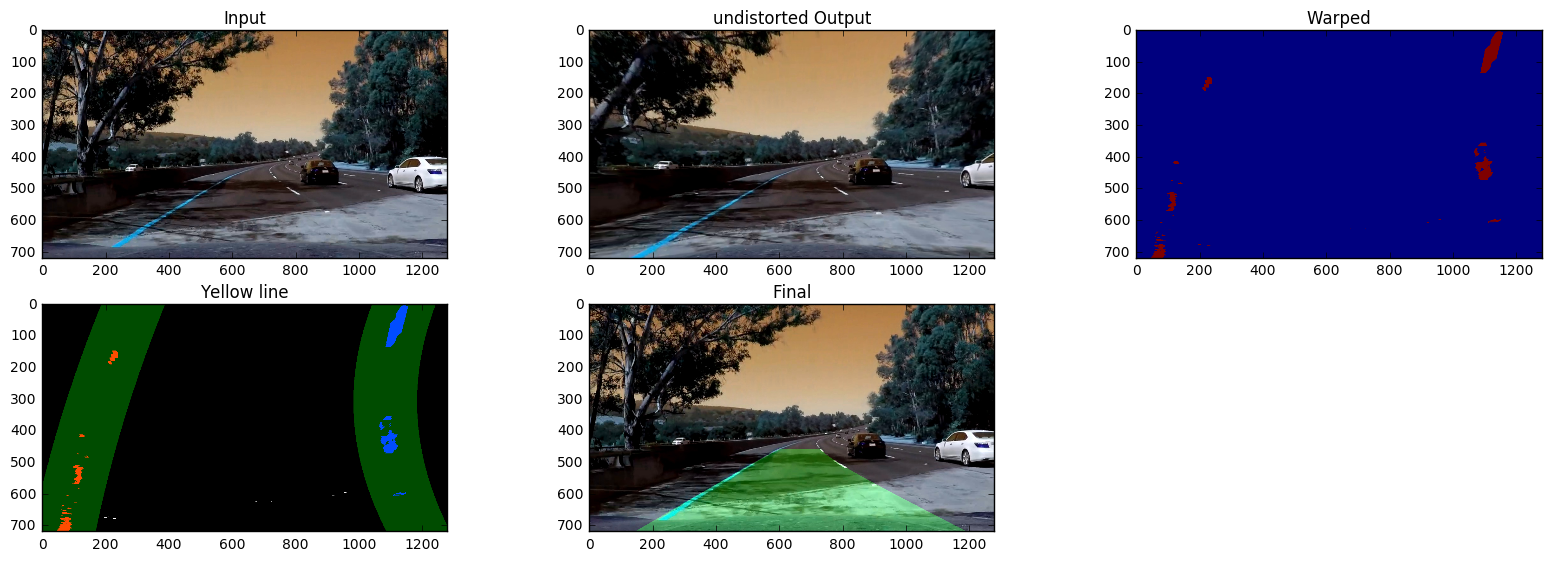

In [67]:
# img = cv2.imread('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/test_images/test1.jpg')
img = cv2.imread('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/submit2/image/img 1036.jpg')
# img = save

a, mtx, dist, d, e = call_m()

img_size = (img.shape[0], img.shape[1])
# print(img_size)
dst = cv2.undistort(img, mtx, dist, None, mtx)

dst_ = np.int32([[dst.shape[1]/2-600,0],[dst.shape[1]/2+600,0],[dst.shape[1]/2+600,720],[dst.shape[1]/2-600,720]])

dst1 = dst.copy()

plt.subplots(figsize = (20,10))
plt.subplot(331),plt.imshow(img),plt.title('Input')
plt.subplot(332),plt.imshow(dst),plt.title('undistorted Output')

src = np.int32(
    [
    [(img_size[1] / 2) - 75, img_size[0] / 2 + 100],
    [(img_size[1] / 2) + 105, img_size[0] / 2 + 100],
    [ img_size[1] / 2 + 600, img_size[0]],
    [ img_size[1] / 2 - 520, img_size[0]]])

print(src)
    
Minv = cv2.getPerspectiveTransform(np.float32(dst_), np.float32(src))

# TRY HSV + sobel_y combined threshold
combined_binary = hsV_sobely(dst)

# TRY HLS + sobel_y combined threshold
# combined_binray = Hls_sobely(dst)


# dst, M, warped = four_point_transform(hls, src)
dst, M, warped = four_point_transform(combined_binary, src)


plt.subplot(333),plt.imshow(warped),plt.title('Warped')

binary_warped = warped

result, left, right, yaxis, text = yel_lane(warped)

left_fitx = left
right_fitx = right
ploty = yaxis

plt.subplot(334),plt.imshow(result),plt.title('Yellow line')

# udist = cv2.warpPerspective(result, Minv, (dst.shape[1], dst.shape[0]))

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))


# # Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

plt.subplot(335),plt.imshow(result), plt.title('Final')
# plt.plot(left_fitx, ploty, color = 'yellow', linewidth = 1)
# plt.plot(right_fitx, ploty, color = 'yellow', linewidth = 1)

plt.show()




## PROCESS FUNCTION FROM THE BEGINNING

In [70]:
def process_image(image):
    
    a,mtx,dist,d,e = call_m()
    
    img = image
    img_size = (img.shape[0], img.shape[1])
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    dst_ = np.int32([[dst.shape[1]/2-600,0],[dst.shape[1]/2+600,0],[dst.shape[1]/2+600,720],[dst.shape[1]/2-600,720]])

    dst1 = dst.copy()
    
    src = np.int32(
        [
        [(img_size[1] / 2) - 75, img_size[0] / 2 + 100],
        [(img_size[1] / 2) + 105, img_size[0] / 2 + 100],
        [ img_size[1] / 2 + 600, img_size[0]],
        [ img_size[1] / 2 - 520, img_size[0]]])


    Minv = cv2.getPerspectiveTransform(np.float32(dst_), np.float32(src))


    # TRY HSV + sobel_y combined threshold
    combined_binary = hsV_sobely(dst)

    # TRY HLS + sobel_y combined threshold
#     combined_binary = Hls_sobely(dst)


    # dst, M, warped = four_point_transform(hls, src)
    dst, M, warped = four_point_transform(combined_binary, src)

    result, left, right, yaxis, text = yel_lane(warped)

    slope_l = img.shape[0]/(left[len(left)-1]-left[0])
    slope_r = img.shape[0]/(right[len(right)-1]-right[0])
   
    left_fitx = left
    right_fitx = right
    ploty = yaxis
    
    
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(dst1, 1, newwarp, 0.3, 0)
    
    cv2.putText(result,text,(0,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),3)



    return result


## VIDEO PROCESSING

In [71]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [74]:
white_output = 'Test.mp4'
path = '/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Submit2'
clip1 = VideoFileClip(path + "/project_video.mp4")
# clip1 = VideoFileClip("project_video.mp4")

In [75]:
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video Test.mp4
[MoviePy] Writing video Test.mp4


100%|█████████▉| 1260/1261 [05:00<00:00,  4.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Test.mp4 

CPU times: user 5min 44s, sys: 53.6 s, total: 6min 38s
Wall time: 5min


# FACED ERROR DURING THE TEST
* frame616 doesn't fit in the HSL threshold, need to merge HSL threshold with something else

In [227]:
clip1 = VideoFileClip("project_video.mp4")
# print(clip1.fps)
# error = clip1.to_ImageClip(t=0)
# myclip = clip1.save_frame("error1.jpeg")

In [258]:
# import the necessary packages
# from ..convenience import is_cv3
# import cv2

def count_frames(path, override=False):
	# grab a pointer to the video file and initialize the total
	# number of frames read
	video = cv2.VideoCapture(path)
	total = 0

	# if the override flag is passed in, revert to the manual
	# method of counting frames
	if override:
		total = count_frames_manual(video)

	# otherwise, let's try the fast way first
	else:
		# lets try to determine the number of frames in a video
		# via video properties; this method can be very buggy
		# and might throw an error based on your OpenCV version
		# or may fail entirely based on your which video codecs
		# you have installed
		try:
			# check if we are using OpenCV 3
			if is_cv3():
				total = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

			# otherwise, we are using OpenCV 2.4
			else:
				total = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))

		# uh-oh, we got an error -- revert to counting manually
		except:
			total = count_frames_manual(video)

	# release the video file pointer
	video.release()

	# return the total number of frames in the video
	return total

def count_frames_manual(video):
	# initialize the total number of frames read
	total = 0

	# loop over the frames of the video
	while True:
		# grab the current frame
		(grabbed, frame) = video.read()
	 
		# check to see if we have reached the end of the
		# video
		if not grabbed:
			break

		# increment the total number of frames read
		total += 1
        
	# return the total number of frames in the video file
	return total

In [259]:
count_frames("/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/project_video.mp4")

1260

In [260]:
path = "/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/project_video.mp4"
video = cv2.VideoCapture(path)

In [264]:
grabbed, frame = video.read()

In [279]:
frame.shape

(720, 1280, 3)

In [280]:
total = 0

while True:
    grabbed, frame = video.read()
    
    if not grabbed:
        break
    total += 1
    
    if total == 616:
        save = frame
        break
    

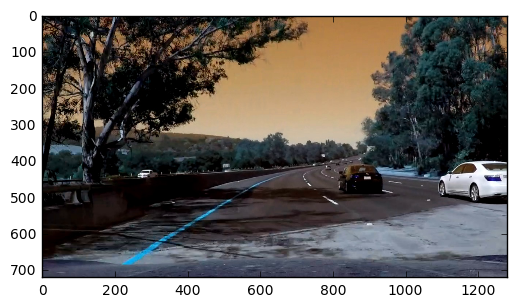

In [359]:
plt.imshow(save)

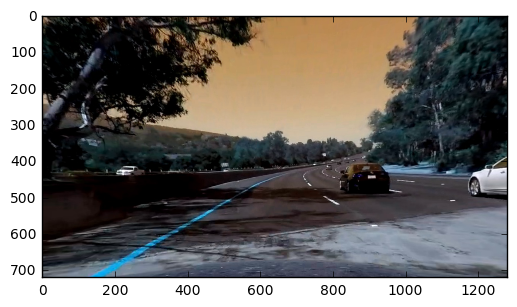

In [360]:
### Tried other filers for the frame occuring error
plt.imshow(dst)

error: /Users/jenkins/miniconda/1/x64/conda-bld/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7935: error: (-215) depth == CV_8U || depth == CV_16U || depth == CV_32F in function cvtColor


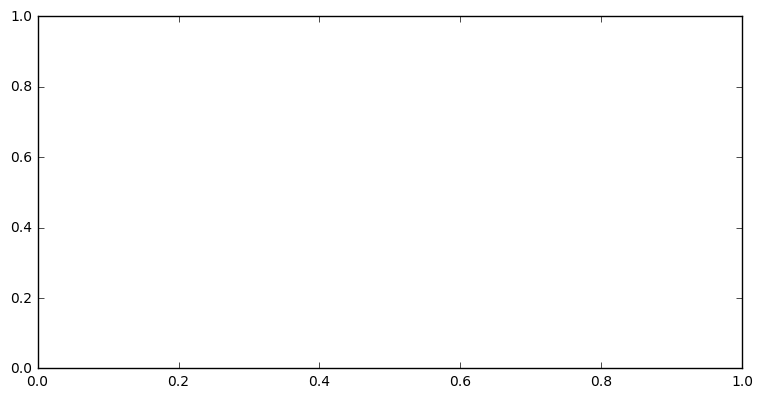

In [383]:
plt.subplots(figsize = (20,10))
plt.subplot(221),plt.imshow(dir_threshold(dst, thresh =(0,5)), cmap='gray'),plt.title('dir')
plt.subplot(222),plt.imshow(abs_sobel_thresh(dst, orient = 'y', thresh_min = 50, thresh_max = 200), cmap='gray'),plt.title('sobel_y')
plt.subplot(223),plt.imshow(abs_sobel_thresh(dst, orient = 'x', sobel_kernel = 1, thresh_min = 50, thresh_max = 250), cmap='gray'),plt.title('sobel_x')
plt.subplot(224),plt.imshow(mag_thresh(dst, mag_thresh=(20,50)), cmap='gray'),plt.title('mag')
plt.show()


### It seems like adding sobel threshold with HLS threshold could be effective
* Lets try

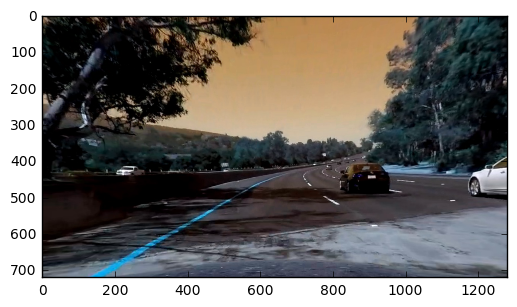

In [342]:
# TRY RGB 

R = dst[:,:,0]
G = dst[:,:,1]
B = dst[:,:,2]

thresh = (150, 250)

def rgb_img(color, thresh):
    binary = np.zeros_like(color)
    binary[(color > thresh[0]) & (color <= thresh[1])] = 1
    return binary

plt.imshow(dst)

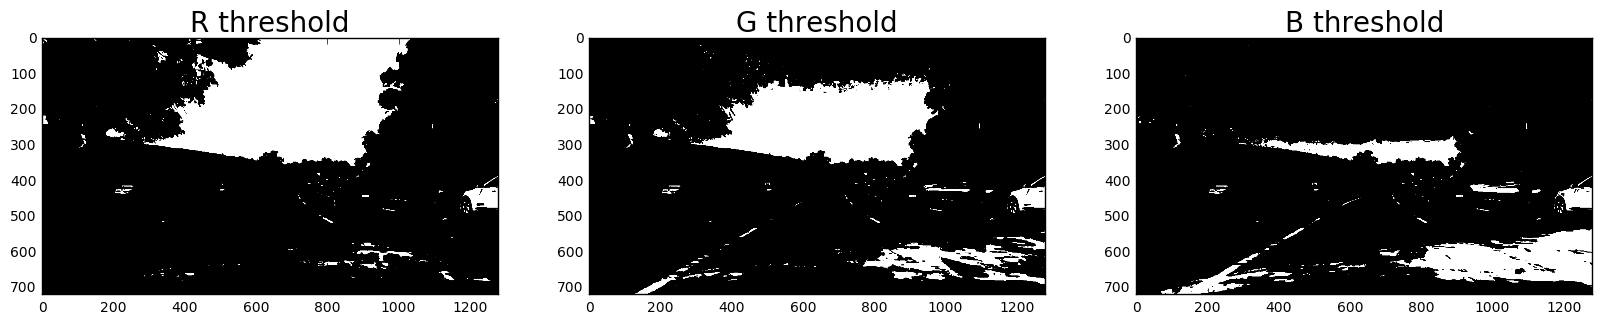

In [343]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,10))
ax1.set_title('R threshold', fontsize= 20)
ax1.imshow(hls_img(R, thresh), cmap = 'gray')
ax2.set_title('G threshold', fontsize= 20)
ax2.imshow(hls_img(G, thresh), cmap = 'gray')
ax3.set_title('B threshold', fontsize= 20)
ax3.imshow(hls_img(B, thresh), cmap = 'gray')



### It seems like G and B might work instead of HSV.
### let's try other images as HSV threshold did

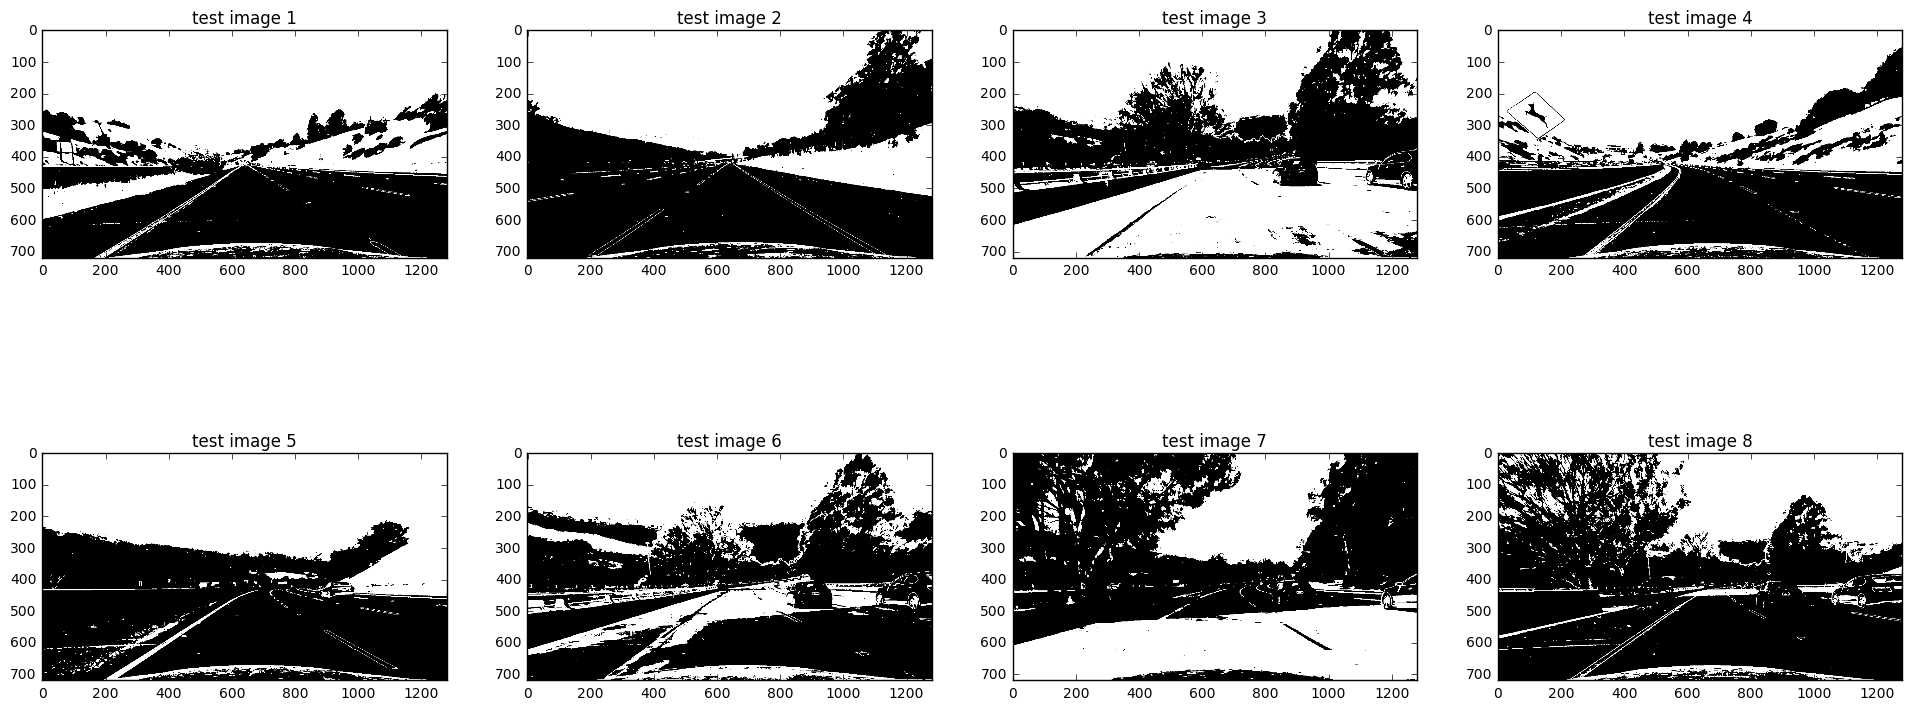

In [317]:
images = glob.glob('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/test_images/*.jpg')

fig = plt.subplots(2,4, figsize = (24,10))
i = 0

# Step through the list and search for chessboard corners
for fname in images:
#     print(fname)
    img = cv2.imread(fname)
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
#     ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, img.shape[::-1],None,None)

    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    
    G = dst[:,:,1]

    thresh = (100, 200)
    
    n_dst = rgb_img(G, thresh)
    
    temp = 241 + i
    ax = plt.subplot(temp)
    plt.imshow(n_dst, cmap = 'gray')
    ax.set_title('test image %i' %(i + 1))
#     axes[i].set_title('Test images ' & i)
    
#     axes[i].imshow(n_dst, cmap = 'gray')
    
    i = i+1
        

### G Threshold not working well with test images. there are too many noises more than HLS
### What about B threshold !!!

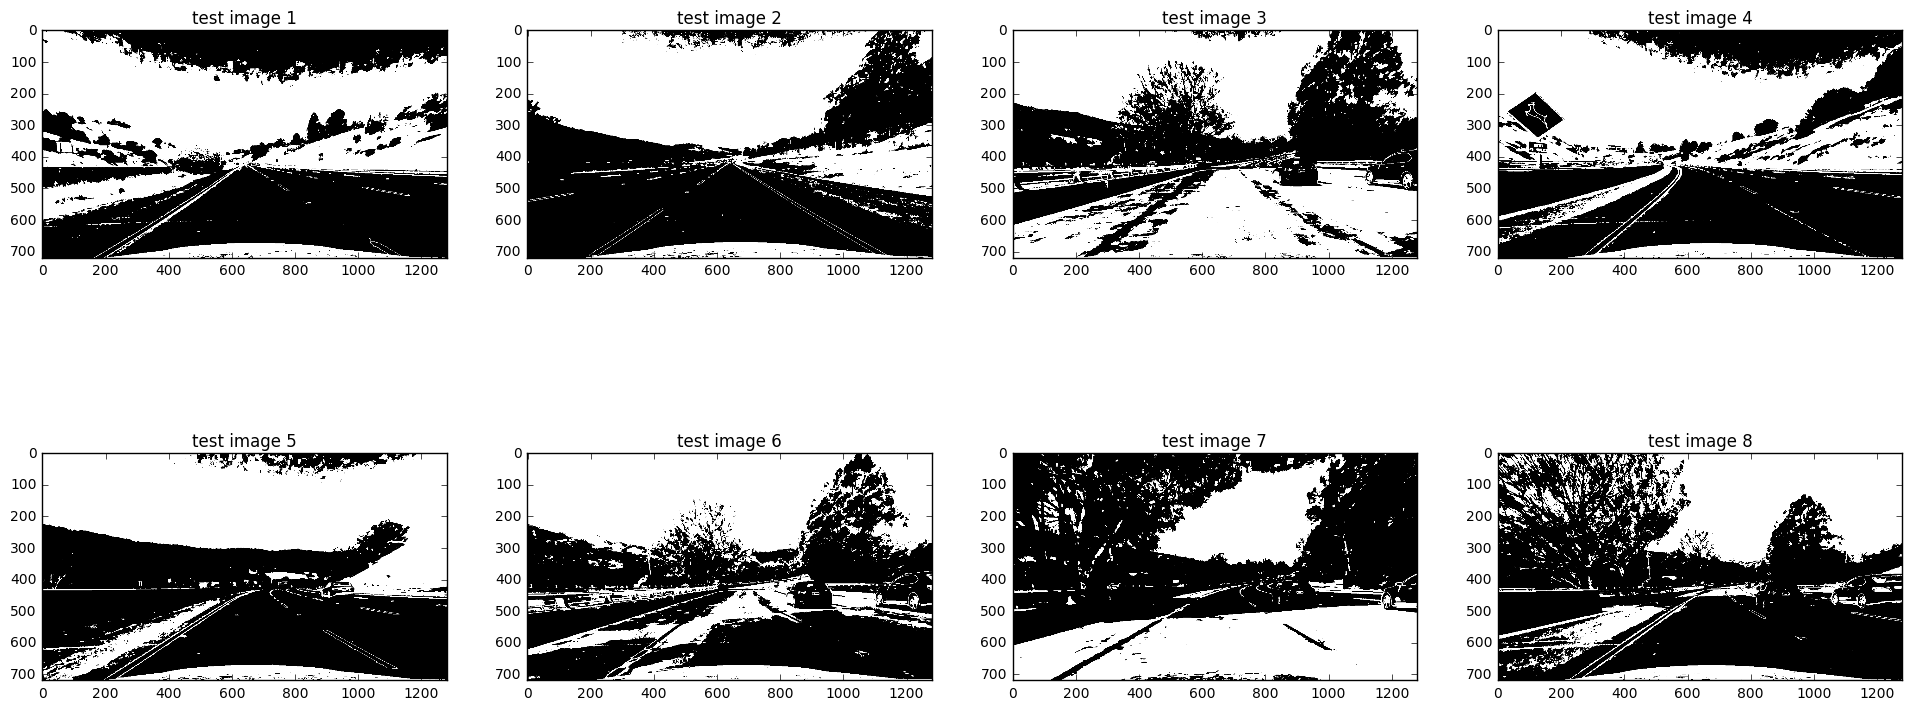

In [318]:
images = glob.glob('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Initial_Submit/test_images/*.jpg')

fig = plt.subplots(2,4, figsize = (24,10))
i = 0

# Step through the list and search for chessboard corners
for fname in images:
#     print(fname)
    img = cv2.imread(fname)
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
#     ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, img.shape[::-1],None,None)

    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    
    B = dst[:,:,2]

    thresh = (100, 200)
    
    n_dst = rgb_img(B, thresh)
    
    temp = 241 + i
    ax = plt.subplot(temp)
    plt.imshow(n_dst, cmap = 'gray')
    ax.set_title('test image %i' %(i + 1))
#     axes[i].set_title('Test images ' & i)
    
#     axes[i].imshow(n_dst, cmap = 'gray')
    
    i = i+1
        

### Not good with B theshold. There are also too many white noise
### HLS was the best so far. then how could find the best filter

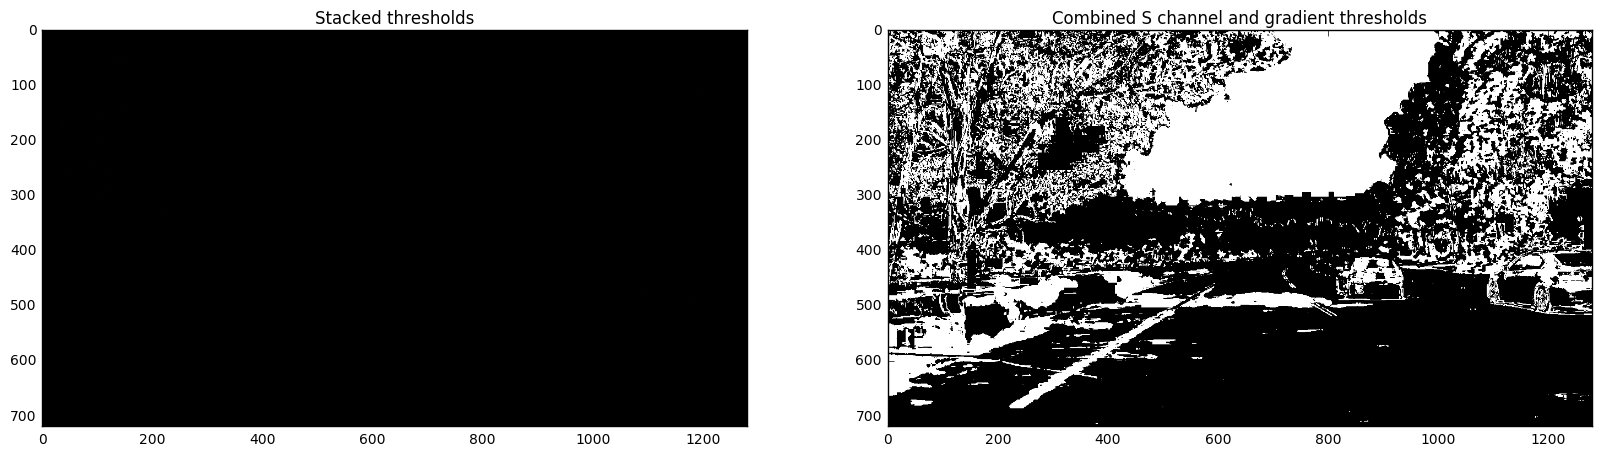

In [344]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
img = save

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 50
thresh_max = 200
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 90
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

# BINGGO!!

# SANITY CHECK

In [47]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [115]:
# total = 0
path = "/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/submit2/project_video.mp4"
video = cv2.VideoCapture(path)

In [141]:
total = 0

old_l = -5
old_r = 2

while True:
    grabbed, frame = video.read()
    
    if not grabbed:
        break
    total += 1
    
    save, slope_l, slope_r = process_image(frame)
    
    if abs(slope_l - old_l)>2 or abs(slope_r - old_r)>2:
        print(old_l, old_r, total-1)
        print(slope_l, slope_r, total)
        
    old_l = slope_l
    old_r = slope_r

    if total > 100:
        break
        
    

-5 2 0
-2.7819238756 4.6299412186 1


In [195]:
total = 0
path = "/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/submit2/project_video.mp4"
video = cv2.VideoCapture(path)

while True:

    grab, frame = video.read()
    cv2.imwrite("/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Advanced Lane-P4/CarND-Advanced-Lane-Lines/Submit2/IMAGE/img %i.jpg" % total, frame)
    
    total += 1
    
    if total >1100:
        break
